In [1]:
# only permit vertex cover

canonical_order = ['BarabasiAlbert', 'ErdosRenyi', 'PowerlawCluster', 'WattsStrogatz',  'MUTAG', 'ENZYMES', 'PROTEINS',   'IMDB-BINARY', 'COLLAB']
def reorder(df, canonical_order=canonical_order, by='dataset', extras=['dataset','gen_n', 'gen_n_max'], secondary='gen_n', columns=None):
    df['dataset_name_order'] = df[by].map({name: i for i, name in enumerate(canonical_order)})
    if secondary is not None:
        df = df.sort_values(by=['dataset_name_order', secondary])
    else:
        df = df.sort_values(by=['dataset_name_order'])

    df.drop('dataset_name_order', axis =1, inplace=True)

    if columns:
        return df[columns ]
    else:
        return df

In [2]:
import os
os.listdir('/home/bcjexu/maxcut-80/bespoke-gnn4do/training_runs')

['legacy',
 'Testing',
 '230928_snapshot',
 'LiftMP_runs',
 '230924_hparam2',
 '230927_snapshot',
 '230928_runs',
 '230924_hparam',
 '230924_hparam_TU_multiarch',
 '230924_hparam_TU',
 '230926_finetune_ER_runs']

In [3]:
print(list(os.path.join('230927_snapshot', x) for x in os.listdir('/home/bcjexu/maxcut-80/bespoke-gnn4do/training_runs/230927_snapshot')))

['230927_snapshot/230925_TUsmall_GAT_VC', '230927_snapshot/230925_TUsmall_GIN_VC', '230927_snapshot/230925_generated_preset_cut', '230927_snapshot/230925_TUlarge_all_cut', '230927_snapshot/230925_TUsmall_GCNN_VC', '230927_snapshot/230925_generated_liftMP_VC', '230927_snapshot/230925_TUlarge_all_VC', '230927_snapshot/230925_generated_preset_VC', '230927_snapshot/230925_TUsmall_liftMP_VC', '230927_snapshot/230925_TUsmall_GatedGCNN_VC', '230927_snapshot/230925_generated_liftMP_cut']


In [4]:
run_folders = ['LiftMP_runs', '230927_snapshot/230925_TUsmall_GAT_VC', '230927_snapshot/230925_TUsmall_GIN_VC', 
               '230927_snapshot/230925_generated_preset_cut', '230927_snapshot/230925_TUlarge_all_cut', '230927_snapshot/230925_TUsmall_GCNN_VC',
                 '230927_snapshot/230925_generated_liftMP_VC', '230927_snapshot/230925_TUlarge_all_VC', '230927_snapshot/230925_generated_preset_VC', 
                 '230927_snapshot/230925_TUsmall_liftMP_VC', '230927_snapshot/230925_TUsmall_GatedGCNN_VC', '230927_snapshot/230925_generated_liftMP_cut']

run_folders = ['230928_snapshot/230925_TUsmall_GAT_VC', '230928_snapshot/230925_TUsmall_GIN_cut', 
               '230928_snapshot/230925_generated_preset_cut', '230928_snapshot/230925_TUsmall_GAT_cut', 
               '230928_snapshot/230925_TUsmall_liftMP_cut', '230928_snapshot/230925_TUsmall_GCNN_VC', 
               '230928_snapshot/230925_TUsmall_GCNN_cut', '230928_snapshot/230925_generated_liftMP_VC', 
               '230928_snapshot/230925_generated_preset_VC', '230928_snapshot/230925_TUsmall_liftMP_VC', '230928_snapshot/230925_TUsmall_GatedGCNN_VC', 
               '230928_snapshot/230925_TUsmall_VC_32', '230928_snapshot/230925_generated_liftMP_cut', '230928_snapshot/230925_TUsmall_GatedGCNN_cut']

run_folders = ['230928_runs/230925_TUsmall_GAT_VC', '230928_runs/230925_TUsmall_GIN_cut', 
               '230928_runs/230925_generated_preset_cut', '230928_runs/230925_TUsmall_GAT_cut', 
               '230928_runs/230925_TUsmall_liftMP_cut', '230928_runs/230925_TUsmall_GCNN_VC', 
               '230928_runs/230925_TUsmall_GCNN_cut', '230928_runs/230925_generated_liftMP_VC', '230928_runs/230925_generated_preset_VC', 
               '230928_runs/230925_TUsmall_liftMP_VC', '230928_runs/230925_TUsmall_GatedGCNN_VC', '230928_runs/230925_TUsmall_VC_32', 
               '230928_runs/230925_TUlarge_liftMP_cut', '230928_runs/230925_TUlarge_liftMP_VC', '230928_runs/230925_generated_liftMP_cut', '230928_runs/230925_TUsmall_GatedGCNN_cut']


In [5]:
import json
import pandas as pd
import numpy as np

folder_path = '/home/bcjexu/maxcut-80/bespoke-gnn4do/training_runs'
model_list = [os.path.join(folder_path, run_folder, x) for run_folder in run_folders for x in os.listdir(os.path.join(folder_path, run_folder))  ]


rows = []

errored = []
numtimes = 0
for model_folder in model_list:
    try:
        with open(os.path.join(model_folder, 'params.txt'), 'r') as f:
            model_args = json.load(f)
        if model_args['problem_type'] != 'vertex_cover':
            continue
        
        losses = np.load(os.path.join(model_folder, 'valid_scores.npy'))
        test_losses = np.load(os.path.join(model_folder, 'test_scores.npy'))

        modeldict = model_args #{x: model_args[x] for x in params}
        modeldict['max_valid_score'] = max(losses)
        modeldict['max_valid_epoch'] = np.argmax(losses)
        modeldict['scores'] = test_losses[np.argmax(losses)]
        modeldict['baseline'] = False


        scorefile = [x for x in os.listdir(model_folder) if x.startswith("time_and_score")]
        #assert(len(scorefile) <=1)
        if len(scorefile) >= 1:
            times, scores = np.load(os.path.join(model_folder, scorefile[0]))
            modeldict['time_per_pred'] = np.average(times)
            numtimes+=1
        else: 
            # load a dummy
            #times, scores = np.load('/home/bcjexu/maxcut-80/bespoke-gnn4do/training_runs/230924_hparam/paramhash:0a0656a369a5b8e4a4be27e0d04fb3b8c161e7b630caf99b8eaeedcddd6a2b18/time_and_score@@test_results_2023-09-28_01:23:33.np.npy')
            modeldict['time_per_pred'] = np.nan
        

        rows.append(modeldict)
        
    except Exception as e:
        print(f'{e} is wrong w/ {model_folder}')
        errored.append(model_folder)

In [6]:
numtimes

52

In [7]:
# load in baselines
baselines = pd.read_csv('vc_baseline_scores.csv')

gen_n_dict = dict(zip([50, 100, 400], [[50, 100], [100, 200],[400, 500]]))

# unwind them 
for i, baseline in baselines.iterrows():
    #print(baseline.index)
    for col in baselines.keys():
        if col == 'Unnamed: 0':
            continue
        ds = col
        gen_n = np.nan
        if len(col.split('@@')) > 1:
            ds, gen_n = col.split('@@')
            gen_n = gen_n_dict[int(gen_n)]

        row = {'dataset': ds, 'gen_n': gen_n, 'model_type': baseline['Unnamed: 0'], 'scores': baseline[col], 'baseline': True}
        #print(row)
        rows.append(row)


In [8]:
len(errored)

0

In [9]:
df = pd.DataFrame.from_records(rows)

from collections import Counter
Counter(df[df.gen_n == 400].model_type)

for x in df.gen_n:
    if not isinstance(x, list) and x !=100:
        print(x)

        

In [10]:
df['gen_n_list'] = df.gen_n
df['gen_n_max'] = df.gen_n_list.apply(lambda x: int(x[1]) if isinstance(x,list) else x)
df.gen_n = df.gen_n.apply(lambda x: int(x[0]) if isinstance(x,list) else x)


from collections import Counter

Counter(df.gen_n_max)

for x, y in zip(df.gen_n, df.gen_n_max):
    if x!=y : print("hi")

In [11]:
df.keys()
# 'problem_type', 'seed',  'prefix', 'RB_n', 'RB_k', 'log_dir',
relevant_keys = [ 'model_type', 'num_layers',
       'repeat_lift_layers', 'num_layers_project', 'rank', 'vc_penalty', 'gen_n', 'gen_n_max',
       'dataset', 'infinite',  'positional_encoding', 'pe_dimension',
       'max_valid_score', 'max_valid_epoch',
       'scores']

In [12]:
df

,problem_type,seed,prefix,model_type,num_layers,repeat_lift_layers,num_layers_project,rank,dropout,hidden_channels,...,log_dir,device,max_valid_score,max_valid_epoch,scores,baseline,time_per_pred,train_fraction,gen_n_list,gen_n_max
0,vertex_cover,0.0,230925_TUsmall_GAT_VC,GAT,8.0,NaN,4.0,8.0,0.0,32.0,...,training_runs/230925_TUsmall_GAT_VC/paramhash:...,cuda,-17.390000,61.0,-18.900000,False,NaN,NaN,100,100.0
1,vertex_cover,0.0,230925_TUsmall_GAT_VC,GAT,8.0,NaN,4.0,16.0,0.0,32.0,...,training_runs/230925_TUsmall_GAT_VC/paramhash:...,cuda,-68.232000,72.0,-70.890000,False,NaN,NaN,100,100.0
2,vertex_cover,0.0,230925_TUsmall_GAT_VC,GAT,8.0,NaN,4.0,4.0,0.0,32.0,...,training_runs/230925_TUsmall_GAT_VC/paramhash:...,cuda,-22.150000,76.0,-22.666667,False,NaN,NaN,100,100.0
3,vertex_cover,0.0,230925_TUsmall_GAT_VC,GAT,8.0,NaN,4.0,16.0,0.0,32.0,...,training_runs/230925_TUsmall_GAT_VC/paramhash:...,cuda,-21.600000,68.0,-22.683333,False,NaN,NaN,100,100.0
4,vertex_cover,0.0,230925_TUsmall_GAT_VC,GAT,16.0,NaN,4.0,8.0,0.0,32.0,...,training_runs/230925_TUsmall_GAT_VC/paramhash:...,cuda,-8.789474,46.0,-7.947368,False,NaN,NaN,100,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,NaN,NaN,NaN,vertex count,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-39.057502,True,NaN,NaN,NaN,NaN
762,NaN,NaN,NaN,vertex count,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-32.633333,True,NaN,NaN,NaN,NaN
763,NaN,NaN,NaN,vertex count,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,"[400, 500]",500.0
764,NaN,NaN,NaN,vertex count,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN


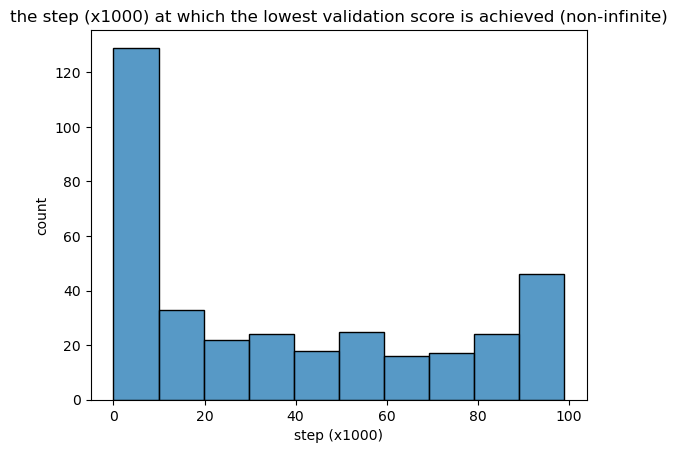

,model_type,num_layers,repeat_lift_layers,num_layers_project,rank,vc_penalty,gen_n,gen_n_max,dataset,infinite,positional_encoding,pe_dimension,max_valid_score,max_valid_epoch,scores
6,GAT,16.0,NaN,4.0,16.0,1.0,100.0,100.0,COLLAB,False,random_walk,8.0,-68.712000,93.0,-71.186000
7,GAT,8.0,NaN,4.0,32.0,1.0,100.0,100.0,PROTEINS,False,laplacian_eigenvector,8.0,-27.963964,94.0,-28.508929
16,GAT,8.0,NaN,4.0,32.0,1.0,100.0,100.0,COLLAB,False,laplacian_eigenvector,8.0,-66.390000,97.0,-68.606000
18,GAT,16.0,NaN,4.0,8.0,1.0,100.0,100.0,COLLAB,False,laplacian_eigenvector,4.0,-68.450000,98.0,-71.088000
22,GAT,8.0,NaN,4.0,32.0,1.0,100.0,100.0,IMDB-BINARY,False,laplacian_eigenvector,8.0,-17.420000,93.0,-18.930000
25,GAT,16.0,NaN,4.0,4.0,1.0,100.0,100.0,COLLAB,False,random_walk,2.0,-68.570000,95.0,-70.894000
27,GAT,8.0,NaN,4.0,16.0,1.0,100.0,100.0,ENZYMES,False,laplacian_eigenvector,8.0,-21.566667,93.0,-22.116667
29,GAT,8.0,NaN,4.0,4.0,1.0,100.0,100.0,COLLAB,False,laplacian_eigenvector,2.0,-66.268000,92.0,-68.480000
30,GAT,8.0,NaN,4.0,4.0,1.0,100.0,100.0,PROTEINS,False,laplacian_eigenvector,2.0,-28.819820,98.0,-28.375000
31,GAT,8.0,NaN,4.0,16.0,1.0,100.0,100.0,PROTEINS,False,laplacian_eigenvector,8.0,-28.405405,94.0,-28.758929


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(df[df.infinite==False].max_valid_epoch)
plt.title('the step (x1000) at which the lowest validation score is achieved (non-infinite)')
plt.xlabel("step (x1000)")
plt.ylabel('count')
plt.show()
df[(df.max_valid_epoch > 90) & (df.infinite==False)][relevant_keys] #.to_csv('230925_checkup_late_bloomers.csv')

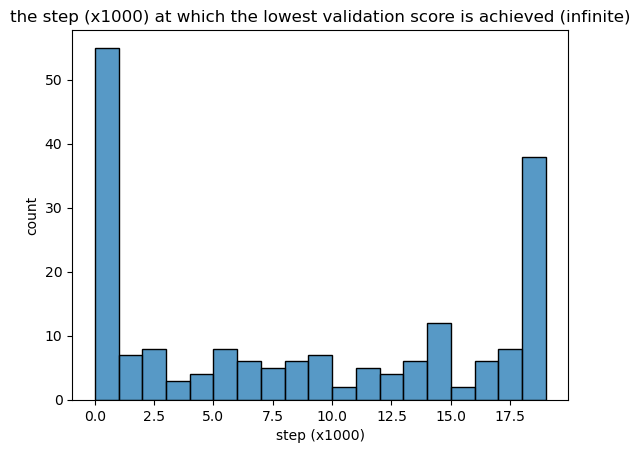

,model_type,num_layers,repeat_lift_layers,num_layers_project,rank,vc_penalty,gen_n,gen_n_max,dataset,infinite,positional_encoding,pe_dimension,max_valid_score,max_valid_epoch,scores
153,LiftMP,8.0,NaN,4.0,4.0,1.0,50.0,100.0,BarabasiAlbert,True,random_walk,2.0,-43.262,19.0,-43.245
157,LiftMP,16.0,NaN,4.0,4.0,1.0,50.0,100.0,ErdosRenyi,True,random_walk,2.0,-56.230,19.0,-56.227
159,LiftMP,16.0,NaN,4.0,16.0,1.0,50.0,100.0,PowerlawCluster,True,random_walk,8.0,-43.066,19.0,-43.061
161,LiftMP,8.0,NaN,4.0,4.0,1.0,50.0,100.0,PowerlawCluster,True,random_walk,2.0,-43.418,19.0,-43.424
162,LiftMP,8.0,NaN,4.0,8.0,1.0,50.0,100.0,PowerlawCluster,True,random_walk,4.0,-43.112,19.0,-43.109
164,LiftMP,8.0,NaN,4.0,4.0,1.0,50.0,100.0,ErdosRenyi,True,random_walk,2.0,-56.543,19.0,-56.553
166,LiftMP,8.0,NaN,4.0,8.0,1.0,400.0,500.0,ErdosRenyi,True,random_walk,4.0,-422.420,19.0,-422.415
167,LiftMP,8.0,NaN,4.0,8.0,1.0,100.0,200.0,ErdosRenyi,True,random_walk,4.0,-126.472,19.0,-126.517
174,LiftMP,16.0,NaN,4.0,16.0,1.0,50.0,100.0,ErdosRenyi,True,random_walk,8.0,-55.595,19.0,-55.619
194,LiftMP,16.0,NaN,4.0,8.0,1.0,50.0,100.0,PowerlawCluster,True,random_walk,4.0,-43.068,19.0,-43.061


In [14]:
sns.histplot(df[df.infinite!=False].max_valid_epoch, bins=range(20))
plt.title('the step (x1000) at which the lowest validation score is achieved (infinite)')
plt.xlabel("step (x1000)")
plt.ylabel('count')
plt.show()
df[(df.max_valid_epoch > 18) & (df.infinite!=False)][relevant_keys] #.to_csv('230925_checkup_late_bloomers.csv')

In [15]:
df.loc[df[df.baseline == False].groupby(['dataset', 'gen_n'])['scores'].idxmax()][relevant_keys]

,model_type,num_layers,repeat_lift_layers,num_layers_project,rank,vc_penalty,gen_n,gen_n_max,dataset,infinite,positional_encoding,pe_dimension,max_valid_score,max_valid_epoch,scores
165,LiftMP,16.0,NaN,4.0,16.0,1.0,50.0,100.0,BarabasiAlbert,True,random_walk,8.0,-42.891000,15.0,-42.882000
224,LiftMP,16.0,NaN,4.0,16.0,1.0,100.0,200.0,BarabasiAlbert,True,random_walk,8.0,-83.439000,11.0,-83.427000
222,LiftMP,16.0,NaN,4.0,8.0,1.0,400.0,500.0,BarabasiAlbert,True,random_walk,4.0,-248.469000,8.0,-248.735000
345,LiftMP,16.0,NaN,4.0,8.0,1.0,100.0,100.0,COLLAB,False,random_walk,4.0,-65.482000,35.0,-67.504000
333,LiftMP,16.0,NaN,4.0,16.0,1.0,100.0,100.0,ENZYMES,False,random_walk,8.0,-18.916667,14.0,-20.000000
146,LiftMP,16.0,NaN,4.0,8.0,1.0,50.0,100.0,ErdosRenyi,True,random_walk,4.0,-55.221000,18.0,-55.247000
167,LiftMP,8.0,NaN,4.0,8.0,1.0,100.0,200.0,ErdosRenyi,True,random_walk,4.0,-126.472000,19.0,-126.517000
235,LiftMP,8.0,NaN,4.0,16.0,1.0,400.0,500.0,ErdosRenyi,True,random_walk,8.0,-420.734000,19.0,-420.701000
360,LiftMP,16.0,NaN,4.0,8.0,1.0,100.0,100.0,IMDB-BINARY,False,random_walk,4.0,-15.420000,20.0,-16.760000
336,LiftMP,8.0,NaN,4.0,16.0,1.0,100.0,100.0,MUTAG,False,random_walk,8.0,-8.736842,0.0,-7.736842


In [16]:
df.gen_n = df.gen_n.fillna("")
df.gen_n_max = df.gen_n_max.fillna("")

In [17]:
df.dataset

0        IMDB-BINARY
1             COLLAB
2            ENZYMES
3            ENZYMES
4              MUTAG
           ...      
761         PROTEINS
762          ENZYMES
763    WattsStrogatz
764           RANDOM
765         ForcedRB
Name: dataset, Length: 766, dtype: object

In [18]:
# test models

models_for_test = []

In [19]:
dataset_by_arc = pd.DataFrame()
dss = ['BarabasiAlbert', 'ErdosRenyi', 'PowerlawCluster', 'WattsStrogatz']
mts = ['SDP proj', 'gurobi_2.0', 'gurobi_4.0', 'gurobi_8.0', 'vertex count']



for (mt, ds, gen_n), group in df[(df.infinite == False) | (df.dataset == 'ErdosRenyi')].groupby(['model_type', 'dataset', 'gen_n']):
    if mt in mts:
        continue
    if all(group['scores'].isna()):
        continue
    if ds not in dss:
        gen_n = ""

    #print(mt, ds, gen_n)
    if ds in dss:
        dataset_by_arc.at[f'{ds}, {gen_n}', mt] = f'{-1*group["scores"].max():0.2f} ({df.loc[group["scores"].idxmax()]["time_per_pred"]*1000:0.0f})'
        dataset_by_arc.at[f'{ds}, {gen_n}', 'gen_n'] = gen_n
        dataset_by_arc.at[f'{ds}, {gen_n}', 'dataset'] = ds
    else: 
        dataset_by_arc.at[f'{ds}', 'gen_n'] = gen_n
        dataset_by_arc.at[f'{ds}', mt] = f'{-1*group["scores"].max():0.2f} ({df.loc[group["scores"].idxmax()]["time_per_pred"]*1000:0.0f})'
        dataset_by_arc.at[f'{ds}', 'dataset'] = ds

    try:
        models_for_test.append((df.loc[group['scores'].idxmax()]['log_dir'], df.loc[group['scores'].idxmax()]['dataset'], df.loc[group['scores'].idxmax()]['gen_n'])) 
    except Exception as e:
        print(f'{e}')




#dataset_by_arc['dataset'] = dataset_by_arc.index
reorder(dataset_by_arc[[k for k in dataset_by_arc.keys() if k not in ['SDP lift', 'edge count']]], by='dataset', columns = ['dataset', 'gen_n', 'GAT', 
                                                                                                                            'GCNN', 'GIN', 'GatedGCNN', 'LiftMP']).to_csv('Table1_VC.csv', index=False) #.style.highlight_max(color = 'green', axis = 1)

In [20]:
dataset_by_arc = pd.DataFrame()
mts = ['GAT', 'GCNN', 'GIN', 'GatedGCNN']
dss = ['BarabasiAlbert', 'ErdosRenyi', 'PowerlawCluster', 'WattsStrogatz']

for (mt, ds, gen_n, gen_nmax), group in df[~df.model_type.isin(mts)].groupby(['model_type', 'dataset', 'gen_n', 'gen_n_max']):

    #if mt =='gurobi_4.0': print(ds) # and ds =='MUTAG': print("hi")

    if all(group['scores'].isna()):
        continue
    if ds not in dss:
        gen_n = ""
        gen_nmax = ""
    #print(mt, ds, gen_n)
    if ds in dss:
        k = f'{ds}_{gen_n}'
    else:
        k = ds
    dataset_by_arc.at[k, 'Type'] = ds
    dataset_by_arc.at[k, 'Nmin'] = gen_n
    dataset_by_arc.at[k, 'Nmax'] = gen_nmax
    if mt not in  ['LiftMP'] + mts:
        dataset_by_arc.at[k, mt] = -1*group['scores'].max()
    else:
        dataset_by_arc.at[k, mt] = f'{-1*group["scores"].max():0.2f} ({df.loc[group["scores"].idxmax()]["time_per_pred"]*1000:0.0f})'
    try:
        models_for_test.append((df.loc[group['scores'].idxmax()]['log_dir'], df.loc[group['scores'].idxmax()]['dataset'], df.loc[group['scores'].idxmax()]['gen_n'])) 
    except Exception as e:
        print(f'{e}')

#dataset_by_arc.rename(columns={'Nikos': 'CustomLiftProject'}, inplace=True)
reorder(dataset_by_arc[[k for k in dataset_by_arc.keys() if k not in ['SDP lift', 'vertex count']]], by='Type', secondary='Nmin').round(2).to_csv('Table2_VC.csv') #.style.highlight_max(color = 'green', axis = 1)

/tmp/ipykernel_1780633/396912827.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dataset_name_order'] = df[by].map({name: i for i, name in enumerate(canonical_order)})


In [21]:
reorder(dataset_by_arc[[k for k in dataset_by_arc.keys() if k not in ['SDP lift', 'vertex count']]], by='Type', secondary='Nmin').round(2).keys()

/tmp/ipykernel_1780633/396912827.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dataset_name_order'] = df[by].map({name: i for i, name in enumerate(canonical_order)})


Index(['Type', 'Nmin', 'Nmax', 'LiftMP', 'SDP proj', 'greedy', 'gurobi_0.1',
       'gurobi_0.5', 'gurobi_1.0', 'gurobi_2.0', 'gurobi_4.0', 'gurobi_8.0'],
      dtype='object')

models_for_test

df[(df.model_type == 'gurobi_4.0') & (df.dataset == 'ENZYMES')]

In [22]:
for x in models_for_test:
    print(x)

('training_runs/230925_TUsmall_GAT_VC/paramhash:de57fa1521a016a0cb6b10cdd1a67ff40d41b59120ee4e2fe0d337ca47851fa2', 'COLLAB', 100.0)
('training_runs/230925_TUsmall_GAT_VC/paramhash:5b6bc13799537d72c55b97cba305471d47991f956fef297212387201dbf3fc6a', 'ENZYMES', 100.0)
('training_runs/230925_generated_preset_VC/paramhash:67cc7b3b629609758884291f0026ce5eb6e0bd30f0ea6463a3c3d1e37947eacc', 'ErdosRenyi', 50.0)
('training_runs/230925_generated_preset_VC/paramhash:e02f47ff9593804563730ec00684048966fdafb2b41fd155fa5c4c492a4d086f', 'ErdosRenyi', 100.0)
('training_runs/230925_generated_preset_VC/paramhash:d064fe1eb981c37b1a247c3b65e2d615cb269031ae1f7fa7e8d3dc4fd12078a8', 'ErdosRenyi', 400.0)
('training_runs/230925_TUsmall_GAT_VC/paramhash:e05e59da19d3b9400cda931ee0719fca7fe4a644549bbd9d434e7d9a155872ef', 'IMDB-BINARY', 100.0)
('training_runs/230925_TUsmall_GAT_VC/paramhash:495624b7a1906212d046d53a26703bc9f34109db44901638c265ae189e82b103', 'MUTAG', 100.0)
('training_runs/230925_TUsmall_GAT_VC/paramha